In [1]:
%cd ..

/home/oleg/asr-eval


In [2]:
# type: ignore

import typing
from typing import Any, Sequence
from dataclasses import dataclass

import gigaam # pyright: ignore[reportMissingTypeStubs]
from gigaam.model import GigaAMASR # pyright: ignore[reportMissingTypeStubs]
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt

from asr_eval.streaming.sender import StreamingAudioSender
from asr_eval.streaming.caller import transсribe_parallel
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import PartialTranscription, InputChunk, OutputChunk
from asr_eval.streaming.evaluation import get_word_timings, words_count
from asr_eval.align.recursive import align
from asr_eval.align.parsing import split_text_into_tokens
from asr_eval.align.data import Match, MatchesList, Token

In [25]:
# type: ignore

dataset: Dataset = load_dataset('bond005/podlodka_speech')['test'].take(10)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
df = pd.DataFrame(list(dataset))

def get_id(audio: dict[str, Any]) -> str:
    return audio['path']

def get_streaming_sender(id: str, audio: dict[str, Any]) -> dict[str, Any]:
    assert audio['sampling_rate'] == 16_000
    return StreamingAudioSender(
        audio=np.int16(audio['array'] * 32768).tobytes(),
        id=id,
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 10,
        speed_multiplier=1,
        track_history=True,
    )

df['id'] = df.audio.apply(get_id)
df['sender'] = df.apply(lambda row: get_streaming_sender(row.id, row.audio), axis=1)

df = df.iloc[3:4]
df

,audio,transcription,episode,title,id,sender
3,"{'path': 'sound_test_0004.wav', 'array': [-0.0...","Да, это отсутствие долго живущих бранчей. Друг...",132,Дисфункции организаций,sound_test_0004.wav,"StreamingAudioSender(audio=b',\xff""\xfe\xc1\xf..."


In [26]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42')
asr.start_thread()

results = transсribe_parallel(asr=asr, senders=df.sender, n_threads=8)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10


LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/phones/word_boundary.int
LOG (VoskAPI:ReadDataFiles():model.cc:315) Loading subtract G.fst model from /home/oleg

Transcribing sound_test_0004.wav
Transcribed sound_test_0004.wav: да это отсутствие долго живущие бранчей другими словами отсутствие какому- [...]


In [27]:
df['preds'] = [PartialTranscription.join(x) for x in results.values()]

In [28]:
# type: ignore

wer = jiwer.wer(reference=df['transcription'].tolist(), hypothesis=df['preds'].tolist())
print(wer)

0.5625


In [29]:
df['preds'].tolist()

['да это отсутствие долго живущие бранчей другими словами отсутствие какому-то кода но кот сам по себе даже если он не проинтегрированы это ведь не такая уж проблема казалось бы ну да ну ещё немножко пылиться на полке но чуть позже этом юзер получит']

In [30]:
df.iloc[0].sender.history

[InputChunk(data=b'', start_time=0.0, end_time=0.1, put_timestamp=1749195404.021616, get_timestamp=1749195404.0217562),
 InputChunk(data=b'', start_time=0.1, end_time=0.2, put_timestamp=1749195404.1217825, get_timestamp=1749195404.1219056),
 InputChunk(data=b'', start_time=0.2, end_time=0.30000000000000004, put_timestamp=1749195404.2224953, get_timestamp=1749195404.2226605),
 InputChunk(data=b'', start_time=0.30000000000000004, end_time=0.4, put_timestamp=1749195404.32281, get_timestamp=1749195404.322954),
 InputChunk(data=b'', start_time=0.4, end_time=0.5, put_timestamp=1749195404.4231405, get_timestamp=1749195404.4233081),
 InputChunk(data=b'', start_time=0.5, end_time=0.6000000000000001, put_timestamp=1749195404.5234685, get_timestamp=1749195404.5236301),
 InputChunk(data=b'', start_time=0.6000000000000001, end_time=0.7000000000000001, put_timestamp=1749195404.623795, get_timestamp=1749195404.6239517),
 InputChunk(data=b'', start_time=0.7000000000000001, end_time=0.8, put_timestamp=

In [31]:
results[df.iloc[0].id]

[OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.0385776, get_timestamp=1749195404.0387366),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.1225727, get_timestamp=1749195404.1226864),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.223313, get_timestamp=1749195404.2235165),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.3236485, get_timestamp=1749195404.3238263),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.4239166, get_timestamp=1749195404.4240954),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.5242693, get_timestamp=1749195404.5244577),
 OutputChunk(data=PartialTranscription(id='__latest__', text='', final=False), put_timestamp=1749195404.6247323, 

In [32]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [33]:
sample = df.iloc[0]

text = sample['transcription']
text = text.lower().replace('ё', 'е').replace('-', ' ')
for char in ('.', ',', '!', '?', ';', ':', '"', '(', ')'):
    text = text.replace(char, '')

word_timings = get_word_timings(gigaam_model, sample['audio']['array'], text)

input_chunks = sample.sender.history
output_chunks = results[sample['id']]

In [34]:
def colorize_predicted_word(match: Match) -> str:
    status = match.get_status()
    true_text = ' '.join([str(x.value) for x in match.true])
    pred_text = ' '.join([str(x.value) for x in match.pred])
    if status == 'correct':
        return pred_text
    elif status == 'insertion':
        return colored(pred_text, 'red')
    elif status == 'deletion':
        return colored(pred_text, 'yellow')
    else:
        return colored(pred_text, 'red')


@dataclass
class PartialAlignment:
    alignment: MatchesList
    audio_seconds_sent: float
    real_seconds_overhead: float = 0


def get_partial_alignments(
    input_history: Sequence[InputChunk],
    output_history: Sequence[OutputChunk],
    true_word_timings: list[tuple[Token, float, float]],
) -> list[PartialAlignment]:
    # check that timings are not None and do not decrease
    assert np.all(np.diff([(x.put_timestamp or np.nan) for x in input_history])[1:] >= 0)
    assert np.all(np.diff([(x.start_time or np.nan) for x in input_history])[1:] >= 0)
    assert np.all(np.diff([(x.end_time or np.nan) for x in input_history])[1:] >= 0)
    assert np.all(np.diff([(x.put_timestamp or np.nan) for x in output_history])[1:] >= 0)

    partial_alignments: list[PartialAlignment] = []

    for i, output_chunk in enumerate(output_history):
        text: str = PartialTranscription.join(output_history[:i + 1])

        pred_tokens = split_text_into_tokens(text)

        chunks_sent = [
            input_chunk for input_chunk in input_history
            if input_chunk.put_timestamp < output_chunk.put_timestamp # pyright: ignore[reportOperatorIssue]
        ]
        audio_seconds_sent: float = chunks_sent[-1].end_time if chunks_sent else 0 # pyright: ignore[reportAssignmentType]

        n_true_words, in_true_word = words_count(true_word_timings, audio_seconds_sent)

        option1 = [word for word, _start, _end in word_timings[:n_true_words]]
        alignment = align(option1, pred_tokens) # pyright: ignore[reportArgumentType]

        if in_true_word:
            option2 = [word for word, _start, _end in word_timings[:n_true_words + 1]]
            alignment2 = align(option2, pred_tokens) # pyright: ignore[reportArgumentType]

            if alignment2.total_n_errs < alignment.total_n_errs or (
                alignment2.total_n_errs == alignment.total_n_errs
                and alignment2.total_n_correct < alignment.total_n_correct
            ):
                alignment = alignment2


        partial_alignments.append(PartialAlignment(
            alignment=alignment,
            audio_seconds_sent=audio_seconds_sent,
            real_seconds_overhead=(
                output_chunk.put_timestamp - chunks_sent[-1].put_timestamp # pyright: ignore[reportOperatorIssue]
                if chunks_sent and len(chunks_sent) == len(input_history)
                else 0
            ),
        ))
    
    return partial_alignments

partial_alignments = get_partial_alignments(input_chunks, output_chunks, word_timings) # type: ignore
partial_alignments

[PartialAlignment(alignment=MatchesList(matches=[], total_true_len=0, total_n_errs=0, total_n_correct=0), audio_seconds_sent=0.1, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[], total_true_len=0, total_n_errs=0, total_n_correct=0), audio_seconds_sent=0.2, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), )], total_true_len=1, total_n_errs=1, total_n_correct=0), audio_seconds_sent=0.30000000000000004, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), )], total_true_len=1, total_n_errs=1, total_n_correct=0), audio_seconds_sent=0.4, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), ), (Token(это, 3-6), )], total_true_len=2, total_n_errs=2, total_n_correct=0), audio_seconds_sent=0.5, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(Token(да, 0-2), ), (Token(это, 3-6), )], total_true_len=2, total_n_errs=2, tota

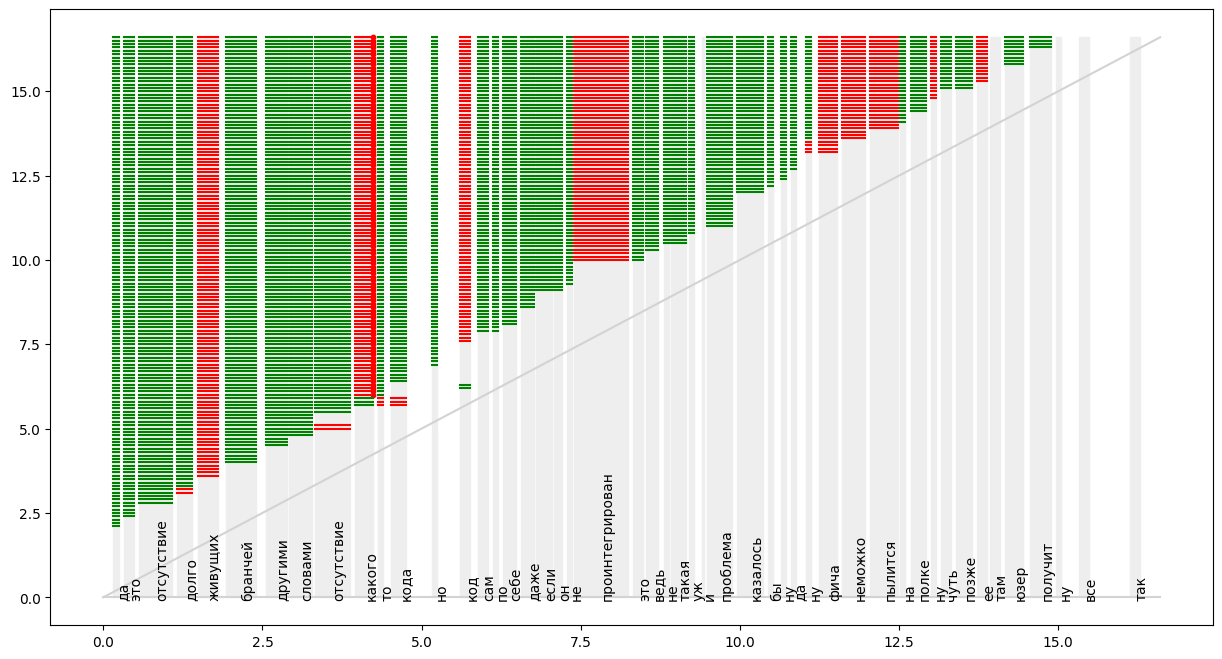

In [41]:
def partial_alignment_diagram(
    partial_alignments: list[PartialAlignment],
    true_word_timings: list[tuple[Token, float, float]],
    audio_len: float,
    figsize: tuple[float, float] = (15, 15),
):
    true_token_id_to_time_span = {
        token.pos: (start, end)
        for token, start, end in true_word_timings
    }

    plt.figure(figsize=figsize)

    # main lines
    plt.plot([0, audio_len], [0, audio_len], color='lightgray')
    plt.plot([0, audio_len], [0, 0], color='lightgray')

    # word timings
    for token, start, end in true_word_timings:
        plt.fill_between([start, end], [0, 0], [audio_len, audio_len], color='#eeeeee', zorder=-1)
        plt.text((start + end) / 2, 0, str(token.value), fontsize=10, rotation=90)

    # partial alignments
    last_end_time = 0
    for partial_alignment in partial_alignments:
        y_pos = partial_alignment.audio_seconds_sent
        for match in partial_alignment.alignment.matches:
            if len(match.true) == 0:
                plt.scatter([last_end_time], [y_pos], color='r', s=10)
            else:
                assert len(match.true) == 1
                start, end = true_token_id_to_time_span[match.true[0].pos]
                last_end_time = end

                status = match.get_status()
                skip = False

                if status == 'correct':
                    color = 'green'
                elif status == 'replacement':
                    color = 'red'
                else:
                    assert status == 'deletion'
                    color = None
                    skip = True
                
                if not skip:
                    plt.plot([start, end], [y_pos, y_pos], color=color)
            pass

    plt.show()

partial_alignment_diagram(
    partial_alignments,
    word_timings,
    audio_len=input_chunks[-1].end_time,  # TODO: may be not precise
    figsize=(15, 8),
)